# Well

Some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import welly
welly.__version__

'0.5.0'

## Make an 'empty' well

In [30]:
w = welly.Well()
w.header  # is empty

,original_mnemonic,mnemonic,unit,value,descr,section


We can set the **UWI** and **name** of a well directly on the well object, but these are the only attributes of the well we can set in this way.

In [31]:
w.uwi = 'foo'
w.uwi

'foo'

In [32]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,UWI,UWI,None,foo,None,header


More usually, we will instantiate a well with some basic data:

In [24]:
w = welly.Well(params={'header': {'name': 'foo', 'uwi':'05045123450000'}})

In [25]:
w.header

{'name': 'foo', 'uwi': '05045123450000'}

In [26]:
w.header['uwi']

'05045123450000'

In [27]:
w.header

{'name': 'foo', 'uwi': '05045123450000'}

The well name and UWI are also provided at the well level for convenience:

In [9]:
w.name, w.uwi

('foo', '05045123450000')

## Load a well from LAS

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [33]:
from welly import Well

In [34]:
w = Well.from_las('data/P-129_out.LAS', remap={'KB': 'EKB', 'UWI': 'WELL'})

The well's `header` contains the basic well information from the **WELL** part of the file.

In [40]:
w.header

,original_mnemonic,mnemonic,unit,value,descr,section
0,VERS,VERS,,2.0,,Version
1,WRAP,WRAP,,YES,,Version
2,STRT,STRT,M,1.0668,START DEPTH,Well
3,STOP,STOP,M,1939.1376,STOP DEPTH,Well
4,STEP,STEP,M,0.1524,STEP,Well
...,...,...,...,...,...,...
137,TLI,TLI,M,280.0,Top Log Interval,Parameter
138,UWID,UWID,,,Unique Well Identification Number,Parameter
139,WN,WN,,Kennetcook #2,Well Name,Parameter
140,EPD,EPD,M,90.300003,Elevation of Permanent Datum above Mean Sea Level,Parameter


The well's `location` contains the location info from **PARAMS**:

In [41]:
w.location

Location({'position': None, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '', 'longitude': '', 'datum': '', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'ekb': 94.8, 'egl': 90.3, 'kb': 94.8, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

In [42]:
w.location.kb

94.8

In [43]:
l = w.to_lasio()

In [44]:
l.well['NULL']

HeaderItem(mnemonic="NULL", unit="", value="-999.25", descr="NULL VALUE")

In [45]:
w.to_las('data/x.las', null_value=-111.111)

In [46]:
!ls -l data/x.las

-rw-rw-r-- 1 matt matt 3517435 Jan  6 14:50 data/x.las


In [47]:
!head -100 data/x.las

~Version ---------------------------------------------------
VERS.   2.0 : CWLS log ASCII Standard -VERSION 2.0
WRAP.    NO : One line per depth step
DLM . SPACE : Column Data Section Delimiter
~Well ------------------------------------------------------
STRT  .m                     1.0668 : START DEPTH
STOP  .m                  1939.1376 : STOP DEPTH
STEP  .m                    0.15240 : STEP
NULL  .                    -111.111 : NULL VALUE
COMP  . Elmworth Energy Corporation : COMPANY
WELL  .               Kennetcook #2 : WELL
FLD   .               Windsor Block : FIELD
LOC   .     Lat = 45* 12' 34.237" N : LOCATION
PROV  .                 Nova Scotia : PROVINCE
CNTY  .                             : COUNTY
STAT  .                             : STATE
CTRY  .                          CA : COUNTRY
SRVC  .                             : SERVICE COMPANY
DATE  .  2022-01-06 14:50:56.211803 : DATE
UWI   .               Kennetcook #2 : UNIQUE WELL ID
API   .                             : API 

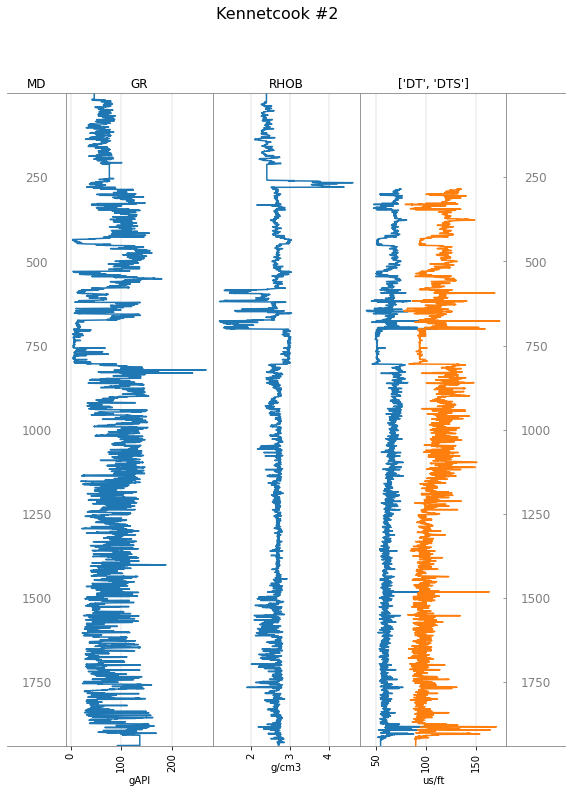

In [48]:
tracks = ['MD', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']
w.plot(tracks=tracks)

## Aliases and curve quality

We can define aliases for curves, and check the quality of curves with a dictionary of tests:

In [49]:
alias = {
    "Gamma": ["GR", "GAM", "GRC", "SGR", "NGT"],
    "Density": ["RHOZ", "RHOB", "DEN", "RHOZ"],
    "Sonic": ["DT", "AC", "DTP", "DT4P"],
    "Caliper": ["CAL", "CALI", "CALS", "C1"],
    'Porosity SS': ['NPSS', 'DPSS'],
}

In [50]:
import welly.quality as q

tests = {
    'Each': [
        q.no_flat,
        q.no_monotonic,
        q.no_gaps,
    ],
    'Gamma': [
        q.all_positive,
        q.all_below(450),
        q.check_units(['API', 'GAPI']),
    ],
    'DT': [
        q.all_positive,
    ],
    'Sonic': [
        q.all_between(1, 10000),  # 1333 to 5000 m/s
        q.no_spikes(10),          # 10 spikes allowed
    ],
}

In [51]:
w = Well.from_las('data/P-129_out.LAS')
r = w.qc_data(tests, alias=alias)

This returns a dictionary of curves in which the values are dictionaries of **test name: test result** pairs.

In [33]:
r

{'CALI': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'HCAL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'PEF': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DT': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': True,
  'all_positive': True,
  'all_between': True,
  'no_spikes': False},
 'DTS': {'no_flat': True, 'no_monotonic': True, 'no_gaps': True},
 'DPHI_SAN': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DPHI_LIM': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DPHI_DOL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_SAN': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_LIM': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_DOL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA5': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA3': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA4': {'no_

There's also an HTML table for rendering in Notebooks:

In [34]:
from IPython.display import HTML
html = w.qc_table_html(tests, alias=alias)
HTML(html)

Curve,Passed,Score,no_gaps,all_below,check_units,all_positive,no_flat,no_spikes,no_monotonic,all_between
CALI,1 / 3,0.333,True,,,,False,,False,
HCAL,1 / 3,0.333,True,,,,False,,False,
PEF,1 / 3,0.333,True,,,,False,,False,
DT,5 / 6,0.833,True,,,True,True,False,True,True
DTS,3 / 3,1.000,True,,,,True,,True,
DPHI_SAN,1 / 3,0.333,True,,,,False,,False,
DPHI_LIM,1 / 3,0.333,True,,,,False,,False,
DPHI_DOL,1 / 3,0.333,True,,,,False,,False,
NPHI_SAN,1 / 3,0.333,True,,,,False,,False,
NPHI_LIM,1 / 3,0.333,True,,,,False,,False,


## Add a striplog

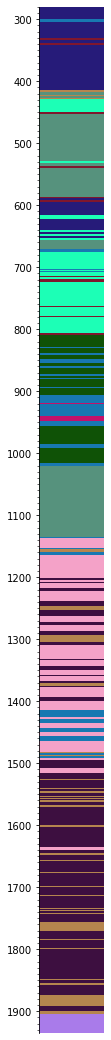

In [35]:
from striplog import Legend, Striplog
legend = Legend.builtin('NSDOE')
strip = Striplog.from_image('data/P-129_280_1935.png', 280, 1935, legend=legend)
strip.plot()

In [36]:
w.data['strip'] = strip

(1000, 1200)

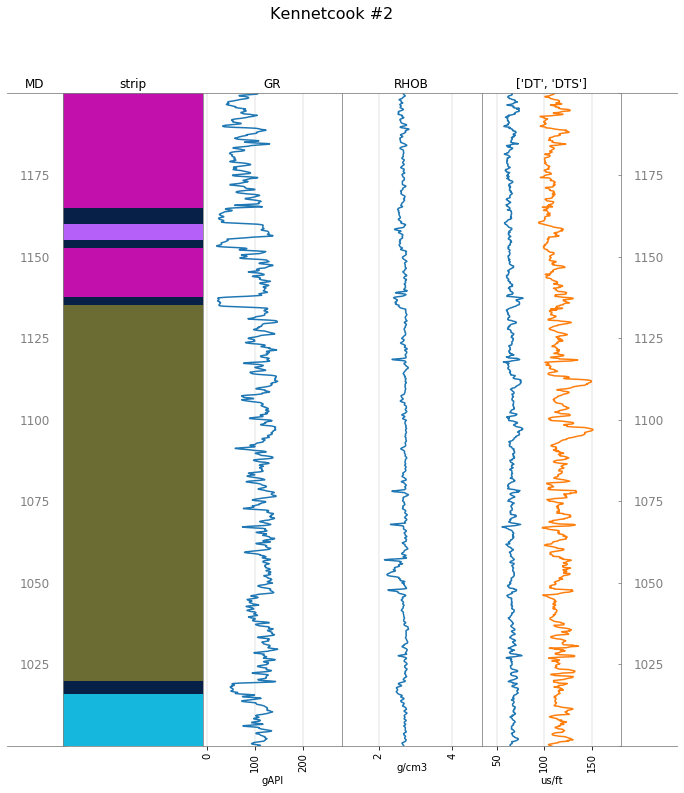

In [37]:
tracks = ['MD', 'strip', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']
w.plot(tracks=tracks)
plt.ylim(1000, 1200)

## Header

Maybe should be called 'meta' as it's not really a header... 

In [38]:
w.header

{'name': 'Kennetcook #2', 'uwi': "Long = 63* 45'24.460  W", 'field': 'Windsor Block', 'license': 'P-129', 'company': 'Elmworth Energy Corporation'}

In [39]:
w.header.name

'Kennetcook #2'

In [40]:
w.uwi  # Fails because not present in this file. See one way to add it in a minute.

"Long = 63* 45'24.460  W"

## Location and CRS

In [41]:
w.location

Location({'position': None, 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'latitude': '', 'longitude': '', 'datum': '', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'ekb': 94.8, 'egl': 90.3, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'td': None, 'deviation': None})

In [42]:
from welly import CRS
w.location.crs = CRS.from_epsg(2038)

In [43]:
w.location.crs

CRS({'init': 'epsg:2038', 'no_defs': True})

Right now there's no position log — we need to load a deviation survey.

In [44]:
w.location.position

## Add deviation data to a well

In [46]:
import numpy as np
from welly import Well

p = Well.from_las('data/P-130_out.LAS')

/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/welly/well.py:192: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


In [47]:
dev = np.loadtxt('data/P-130_deviation_survey.csv', delimiter=',', skiprows=1)

The columns are MD, inclination, azimuth, and TVD.

In [48]:
dev[:5]

array([[ 18. ,   0.3,   0. ,  18. ],
       [ 38. ,   0.5,   0. ,  38. ],
       [ 57. ,   1.5,   0. ,  57. ],
       [ 84. ,   1.8,   0. ,  84. ],
       [104. ,   0.5,   0. , 104. ]])

`add_deviation` assumes those are the columns, and computes a position log.

In [49]:
p.location.add_deviation(dev[:, :3], td=2618.3)

The columns in the position log are _x_ offset, _y_ offset, and TVD.

In [50]:
p.location.position[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.71237821e-02, 1.79999178e+01],
       [0.00000000e+00, 1.86748917e-01, 3.79994202e+01],
       [0.00000000e+00, 5.18340431e-01, 5.69962853e+01],
       [0.00000000e+00, 1.29577626e+00, 8.39850594e+01]])

In [51]:
p.location.trajectory()

array([[ 6.45933639e-01,  3.47023772e-01, -1.65395432e-02],
       [ 5.90396925e-01,  3.28218888e-01, -2.63643779e+00],
       [ 5.36457735e-01,  3.11968468e-01, -5.25632568e+00],
       ...,
       [-3.68094384e+00,  3.97484953e+01, -2.61112780e+03],
       [-3.68832058e+00,  3.96833189e+01, -2.61374906e+03],
       [-3.69619567e+00,  3.96172858e+01, -2.61637033e+03]])

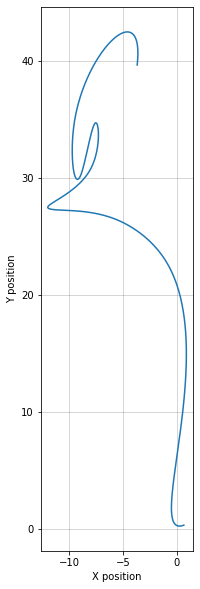

In [52]:
p.location.plot_plan()

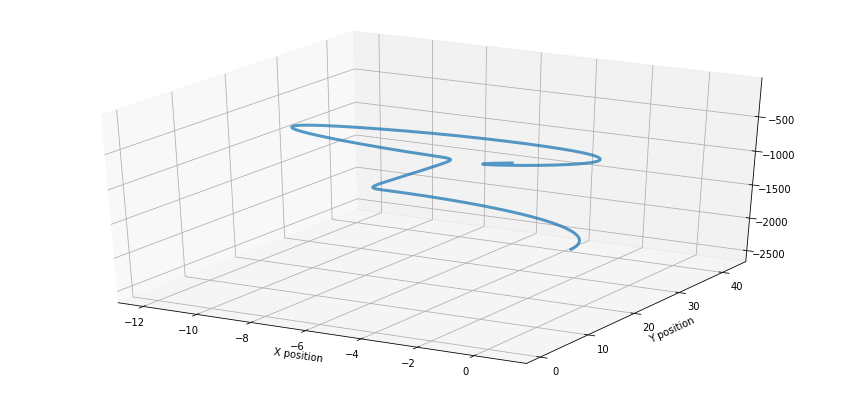

In [53]:
p.location.plot_3d()

## Export curves to data matrix

Make a NumPy array:

In [54]:
w.data_as_matrix()

array([[  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       ...,
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.        ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.9375    ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  74.25      ]])

## Export curves to pandas

Pandas is an optional dependency. You'll need it to make this work.

In [55]:
df = w.df()

In [56]:
df.head()

,CALI,HCAL,PEF,DT,DTS,DPHI_SAN,DPHI_LIM,DPHI_DOL,NPHI_SAN,NPHI_LIM,...,RLA1,RLA2,RXOZ,RXO_HRLT,RT_HRLT,RM_HRLT,DRHO,RHOB,GR,SP
Depth,,,,,,,,,,,,,,,,,,,,,
1.0668,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.0321,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125
1.2192,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.0321,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125
1.3716,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.0321,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125
1.5240,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.0321,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125
1.6764,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.0321,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125


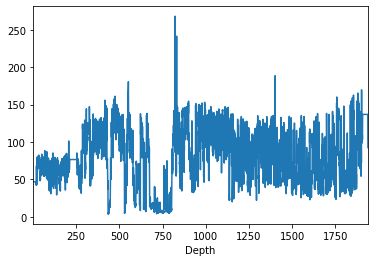

In [57]:
df.GR.plot()

This also gives us another path to getting a matrix:

In [58]:
w.df().values

array([[  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       ...,
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.        ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.9375    ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  74.25      ]])

You'll have to get depth separately:

In [59]:
w.df().index.values

array([1.0668000e+00, 1.2192000e+00, 1.3716000e+00, ..., 1.9388328e+03,
       1.9389852e+03, 1.9391376e+03])

To get the UWI of the well as well, e.g. if you want to combine multiple wells (maybe using `welly.Project.df()`):

In [60]:
df = w.df(uwi=True)

In [61]:
df.head()

CALI      HCAL     PEF  DT  DTS  DPHI_SAN  \
UWI                     Depth                                                   
Long = 63* 45'24.460  W 1.0668  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.2192  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.3716  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.5240  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.6764  2.443815  4.391285  3.5864 NaN  NaN   0.15748   

                                DPHI_LIM  DPHI_DOL  NPHI_SAN  NPHI_LIM  ...  \
UWI                     Depth                                           ...   
Long = 63* 45'24.460  W 1.0668   0.19844    0.2591    0.4651   0.33647  ...   
                        1.2192   0.19844    0.2591    0.4651   0.33647  ...   
                        1.3716   0.19844    0.2591    0.4651   0.33647  ...   
                        1.5240   0.19844    0.2591    0.4651   0.33647  ...   
                        1.6764   0.19844    0.2591    0.4651   0.33647  ...   

                                  RLA1     RLA2     RXOZ  RXO_HRLT  RT_HRLT  \
UWI                     Depth                                                 
Long = 63* 45'24.460  W 1.0668  0.0321  0.02794  0.05761   0.02558  0.02558   
                        1.2192  0.0321  0.02794  0.05761   0.02558  0.02558   
                        1.3716  0.0321  0.02794  0.05761   0.02558  0.02558   
                        1.5240  0.0321  0.02794  0.05761   0.02558  0.02558   
                        1.6764  0.0321  0.02794  0.05761   0.02558  0.02558   

                                RM_HRLT      DRHO     RHOB        GR       SP  
UWI                     Depth                                                  
Long = 63* 45'24.460  W 1.0668  0.05501  0.194233  2.39015  46.69865  120.125  
                        1.2192  0.05501  0.194233  2.39015  46.69865  120.125  
                        1.3716  0.05501  0.194233  2.39015  46.69865  120.125  
                        1.5240  0.05501  0.194233  2.39015  46.69865  120.125  
                        1.6764  0.05501  0.194233  2.39015  46.69865  120.125  

[5 rows x 24 columns]

### Pandas with an alias dictionary

In [62]:
alias

{'Gamma': ['GR', 'GAM', 'GRC', 'SGR', 'NGT'],
 'Density': ['RHOZ', 'RHOB', 'DEN', 'RHOZ'],
 'Sonic': ['DT', 'AC', 'DTP', 'DT4P'],
 'Caliper': ['CAL', 'CALI', 'CALS', 'C1'],
 'Porosity SS': ['NPSS', 'DPSS']}

In [63]:
keys = ['CALI', 'Gamma', 'Density', 'Sonic', 'RLA1']
w.df(keys=keys, alias=alias, rename_aliased=True).head()

,CALI,RLA1
Depth,,
1.0668,2.443815,0.0321
1.2192,2.443815,0.0321
1.3716,2.443815,0.0321
1.5240,2.443815,0.0321
1.6764,2.443815,0.0321
